In [1]:
from fastai.vision import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
movie_genre = pd.read_csv('MovieGenre.csv', encoding='iso-8859-1')
movie_genre.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [3]:
movie_genre.shape

(40108, 6)

In [4]:
movie_genre.dtypes

imdbId          int64
Imdb Link      object
Title          object
IMDB Score    float64
Genre          object
Poster         object
dtype: object

In [5]:
data_path = '../Movie Poster to Genre/posters/'

In [6]:
file_names = get_image_files(data_path)
file_names[:4]

[WindowsPath('../Movie Poster to Genre/posters/1000095.jpg'),
 WindowsPath('../Movie Poster to Genre/posters/100014.jpg'),
 WindowsPath('../Movie Poster to Genre/posters/100024.jpg'),
 WindowsPath('../Movie Poster to Genre/posters/100029.jpg')]

In [7]:
ids_to_select = [int(i.stem) for i in file_names]

In [8]:
data = movie_genre.loc[movie_genre['imdbId'].isin(ids_to_select)].reset_index(drop = True)
data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,106473,http://www.imdb.com/title/tt106473,The Boys of St. Vincent (1992),7.7,Drama,https://images-na.ssl-images-amazon.com/images...
1,103859,http://www.imdb.com/title/tt103859,Boomerang (1992),5.4,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
2,107447,http://www.imdb.com/title/tt107447,Love & Human Remains (1993),6.7,Drama|Comedy,https://images-na.ssl-images-amazon.com/images...
3,103994,http://www.imdb.com/title/tt103994,Como agua para chocolate (1992),7.2,Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,106402,http://www.imdb.com/title/tt106402,Beyond Bedlam (1994),3.4,Comedy|Horror,https://images-na.ssl-images-amazon.com/images...


In [9]:
labels = data[['imdbId','Genre']]
labels

,imdbId,Genre
0,106473,Drama
1,103859,Comedy|Drama|Romance
2,107447,Drama|Comedy
3,103994,Drama|Romance
4,106402,Comedy|Horror
...,...,...
1653,101592,Drama|Thriller|Western
1654,1019437,Family
1655,1015456,Drama
1656,1018706,Drama


In [10]:
labels = labels.dropna()
labels.shape

(1654, 2)

In [11]:
tfms = get_transforms()

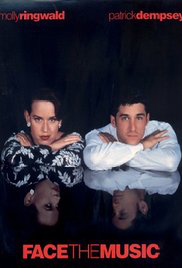

In [12]:
import random

i = random.randint(1,len(file_names))
open_image(file_names[i])

In [13]:
bs = 16

In [14]:
np.random.seed(42)

src = (ImageList.from_df(labels, path='posters', suffix='.jpg')
       .split_by_rand_pct(0.1)
       .label_from_df(label_delim='|'))


C:\Users\Arpan\Anaconda3\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
data = (src.transform(tfms, size=128)
        .databunch(bs = bs, num_workers = 0).normalize(imagenet_stats))

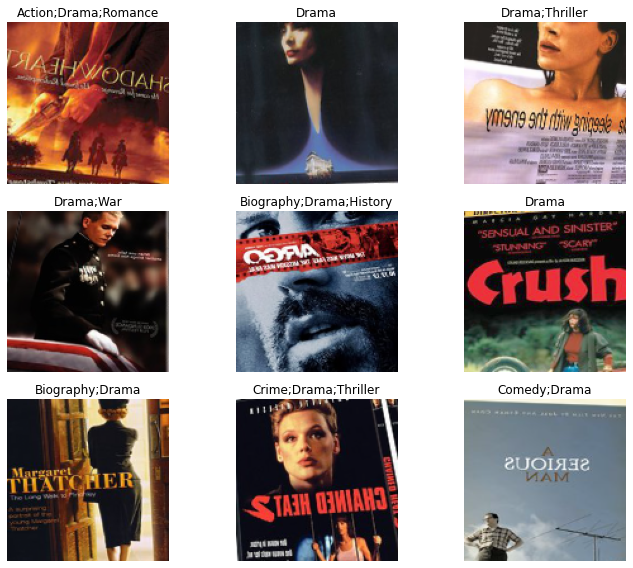

In [17]:
data.show_batch(3, figsize = (10,8))

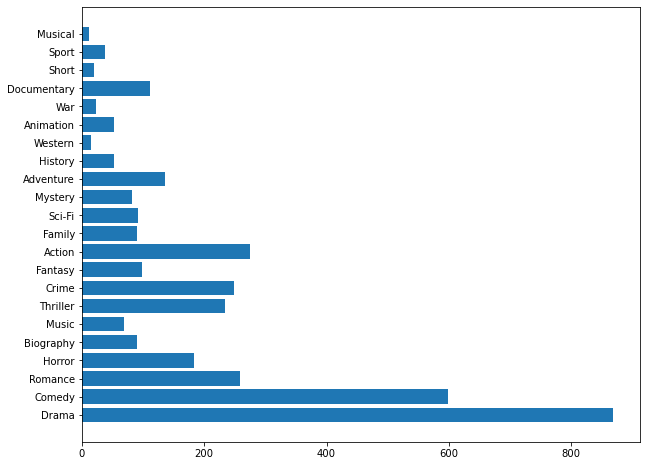

In [18]:
lbl_count = {}

for i in labels.Genre:
    lbl = i.split('|')
    for l in lbl:
        if l in lbl_count:
            lbl_count[l] += 1
        else:
            lbl_count[l] = 1

plt.figure(figsize=(10,8))            
plt.barh(list(lbl_count.keys()), list(lbl_count.values()))
plt.show()

In [18]:
arch = models.resnet50

In [19]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
fbeta = partial(fbeta, thresh = 0.2)

learn = cnn_learner(data, arch, metrics = [acc_02, fbeta])

In [21]:
defaults.device = torch.device('cuda')

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


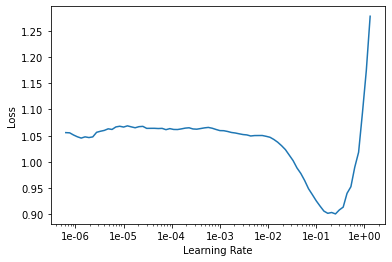

In [23]:
learn.recorder.plot()

In [24]:
lr = 7e-2

In [26]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.338771,0.323390,0.835813,0.398242,00:29
1,0.327186,0.319966,0.847934,0.342555,00:29
2,0.314159,0.280701,0.851791,0.471958,00:29
3,0.283188,0.510748,0.847383,0.514548,00:29
4,0.260677,0.296149,0.879890,0.518918,00:30


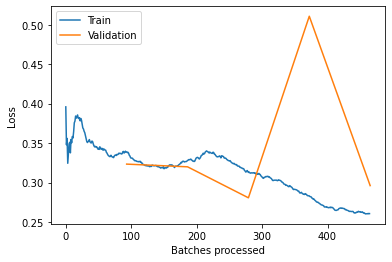

In [27]:
learn.recorder.plot_losses()

In [28]:
learn.save('stage-1-rn50')

In [29]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


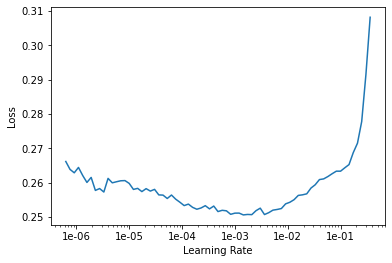

In [30]:
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.load('stage-1-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (1489 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Drama,Comedy;Drama;Romance,Drama;Comedy,Drama;Romance,Comedy;Horror
Path: posters;

Valid: LabelList (165 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Drama,Animation;Family;Fantasy,Drama;Romance,Biography;Drama;Music,Drama
Path: posters;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn

In [39]:
learn.fit_one_cycle(5, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.251746,0.256957,0.866667,0.505187,00:33
1,0.249977,0.309798,0.852066,0.506716,00:33
2,0.247641,0.502921,0.868595,0.541881,00:33
3,0.241768,0.256311,0.863361,0.529302,00:33
4,0.235062,0.256957,0.869421,0.553154,00:33


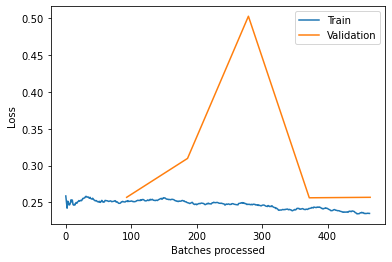

In [40]:
learn.recorder.plot_losses()

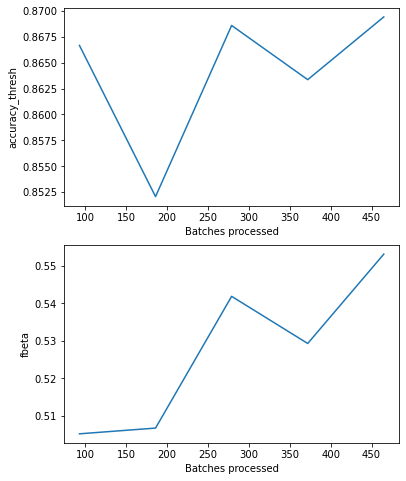

In [41]:
learn.recorder.plot_metrics()

In [42]:
learn.save('stage-2-rn34')

In [15]:
data = src.transform(tfms=tfms, size = 256).databunch(bs = bs, num_workers = 0).normalize(imagenet_stats)

In [25]:
learn.load('stage-2-rn34')

Learner(data=ImageDataBunch;

Train: LabelList (1489 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
Drama,Comedy;Drama;Romance,Drama;Comedy,Drama;Romance,Comedy;Horror
Path: posters;

Valid: LabelList (165 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
Drama,Animation;Family;Fantasy,Drama;Romance,Biography;Drama;Music,Drama
Path: posters;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn

In [26]:
learn.data = data

In [27]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


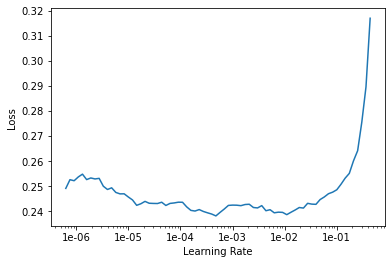

In [28]:
learn.lr_find()
learn.recorder.plot()

In [31]:
lr = 1e-3

In [32]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.240359,0.273829,0.873003,0.537906,01:09
1,0.240411,0.313219,0.875758,0.549022,01:08
2,0.239556,0.275435,0.869697,0.552780,01:09
3,0.236506,0.454982,0.877686,0.551704,01:10
4,0.235189,0.342745,0.877135,0.558779,01:22


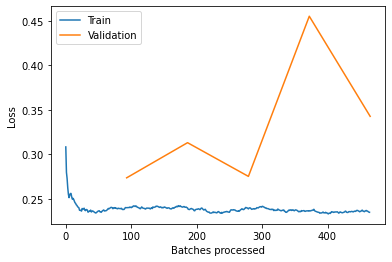

In [33]:
learn.recorder.plot_losses()

In [34]:
learn.save('stage-1-256-rn50')

In [36]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


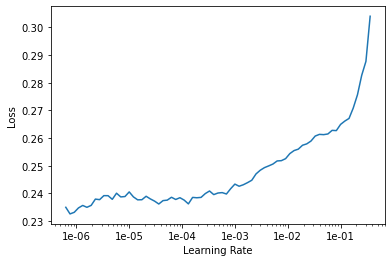

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(10,slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.234476,0.231692,0.869146,0.556313,02:12
1,0.234496,0.237167,0.872176,0.550264,02:13
2,0.233488,0.249857,0.868870,0.545139,02:13
3,0.232008,0.356490,0.866942,0.531449,02:23
4,0.228031,0.281450,0.865565,0.528604,02:21
5,0.227355,0.246030,0.869697,0.542953,02:20
6,0.222307,1.296345,0.860055,0.545568,02:19
7,0.217166,0.338974,0.868044,0.538673,02:31
8,0.216007,0.295544,0.871350,0.541786,02:30
9,0.216019,0.341046,0.871074,0.545733,02:27


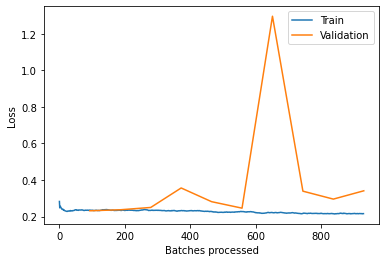

In [39]:
learn.recorder.plot_losses()

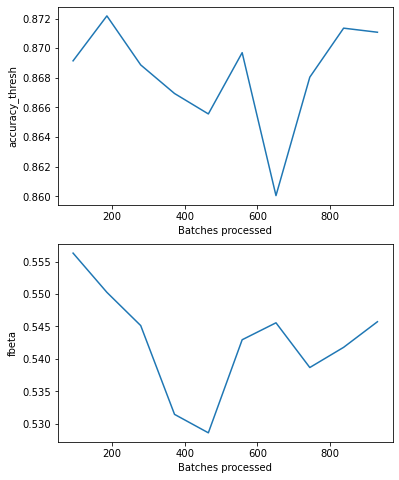

In [41]:
learn.recorder.plot_metrics()

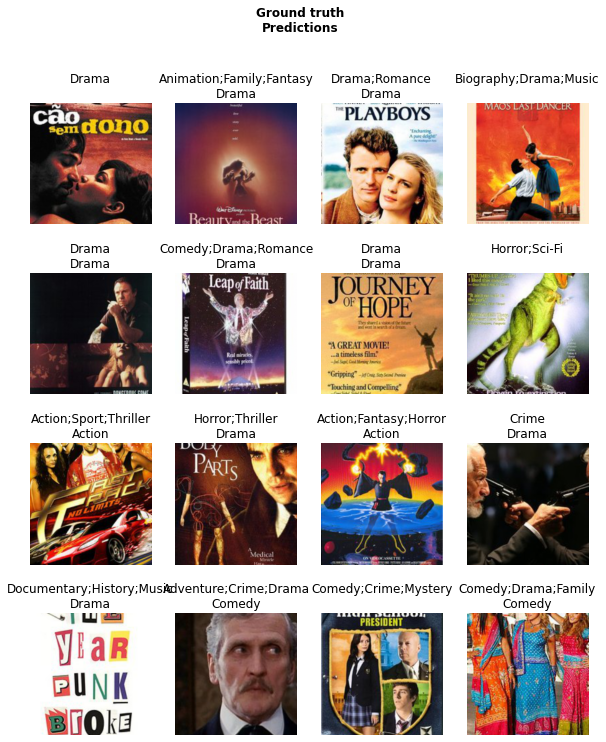

In [46]:
learn.show_results(rows=4, figsize=(10,12))

In [53]:
learn.save('stage-2-256-rn50')

In [57]:
learn.load('stage-2-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (1489 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
Drama,Comedy;Drama;Romance,Drama;Comedy,Drama;Romance,Comedy;Horror
Path: posters;

Valid: LabelList (165 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
Drama,Animation;Family;Fantasy,Drama;Romance,Biography;Drama;Music,Drama
Path: posters;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn

In [59]:
learn.export()

In [60]:
defaults.device = torch.device('cpu')

<AxesSubplot:>

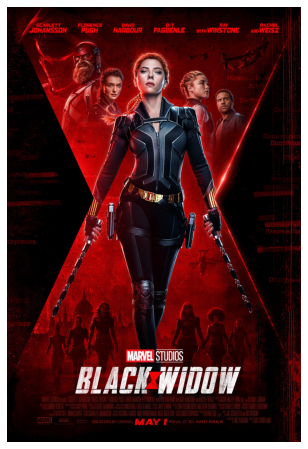

In [78]:
img = open_image('bw.jpeg')
show_image(img, figsize = (10,8))

In [79]:
learn = load_learner(data_path)

In [80]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class.obj

C:\Users\Arpan\Anaconda3\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


['Action', 'Drama']